<a href="https://colab.research.google.com/github/sujitpal/nlp-deeplearning-ai-examples/blob/master/x6_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

### X.6.01: Create Data

Create random dataset of 10 weekly records representing 5 weeks of data, i.e., shape (10,5), then the first 4 columns are data and last 4 columns are targets.

In [2]:
np.random.seed(0)
data = pd.DataFrame(np.random.randint(0, 100, size=(10, 5)),
                    columns=["week1", "week2", "week3", "week4", "week5"])
data.head()

,week1,week2,week3,week4,week5
0,44,47,64,67,67
1,9,83,21,36,87
2,70,88,88,12,58
3,65,39,87,46,88
4,81,37,25,77,72


In [3]:
inputs = data.iloc[:, :-1]
targets = data.iloc[:, 1:]

inputs.shape, targets.shape

((10, 4), (10, 4))

## A.6.01: RNN for Time Series Prediction

### Data

Dataset to use: [Sales Transactions Weekly Dataset](https://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly) from UCI-ML repository.


In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv

--2020-08-15 22:52:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317399 (310K) [application/x-httpd-php]
Saving to: ‘Sales_Transactions_Dataset_Weekly.csv.2’

Sales_Transactions_ 100%[===================>] 309.96K   537KB/s    in 0.6s    

2020-08-15 22:52:28 (537 KB/s) - ‘Sales_Transactions_Dataset_Weekly.csv.2’ saved [317399/317399]



In [5]:
sales_data = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")
sales_data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,...,Normalized 12,Normalized 13,Normalized 14,Normalized 15,Normalized 16,Normalized 17,Normalized 18,Normalized 19,Normalized 20,Normalized 21,Normalized 22,Normalized 23,Normalized 24,Normalized 25,Normalized 26,Normalized 27,Normalized 28,Normalized 29,Normalized 30,Normalized 31,Normalized 32,Normalized 33,Normalized 34,Normalized 35,Normalized 36,Normalized 37,Normalized 38,Normalized 39,Normalized 40,Normalized 41,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,...,0.72,0.33,0.33,0.33,0.61,0.33,0.00,0.50,0.11,0.44,0.22,0.50,0.11,0.33,0.22,0.39,0.11,0.44,0.22,0.39,0.50,0.17,0.11,0.61,0.39,0.33,0.50,0.78,0.22,0.44,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,...,0.60,0.20,0.00,0.60,0.20,0.70,0.70,0.90,0.40,0.70,0.20,0.40,0.50,0.30,0.50,0.80,0.50,0.50,0.30,0.10,0.30,0.20,0.30,1.00,0.50,0.20,0.70,0.30,0.20,0.50,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,...,0.09,0.36,0.82,0.45,0.36,0.73,0.64,0.36,0.36,0.91,0.73,0.45,0.64,0.45,1.00,0.18,0.00,0.91,0.73,0.55,0.36,0.45,0.36,0.55,0.27,0.82,0.82,0.55,0.00,0.18,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,...,0.18,0.12,0.76,0.29,0.53,0.41,0.76,0.12,0.24,0.29,0.53,0.29,0.41,0.24,0.47,0.47,0.00,0.24,0.29,0.00,0.18,0.59,0.18,1.00,0.35,0.24,0.35,0.35,0.59,0.24,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,...,0.33,0.07,0.67,0.33,0.47,0.80,0.20,0.67,0.53,0.20,0.47,0.40,0.33,0.60,0.33,0.40,0.67,0.00,0.13,0.00,0.13,0.13,0.40,0.27,0.07,0.33,0.33,0.13,0.13,0.33,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [6]:
data = sales_data.values[:, 1:53]
data.shape

(811, 52)

### Visualize Data

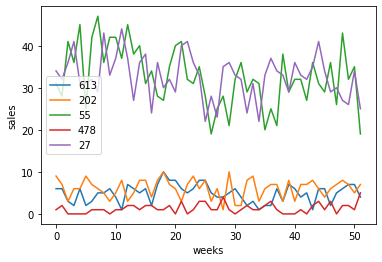

In [7]:
np.random.seed(0)
for i in np.random.choice(np.arange(data.shape[0]), size=5, replace=False):
  plt.plot(np.arange(data.shape[1]), data[i], label="{:d}".format(i))

plt.ylabel("sales")
plt.xlabel("weeks")
plt.legend(loc="best")
_ = plt.show()

### Datasets

In [8]:
inputs = np.array(data[:, 0:-1], dtype=np.int32)
targets = np.array(data[:, 1:], dtype=np.int32)

inputs = np.expand_dims(inputs, axis=2)
targets = np.expand_dims(targets, axis=2)

inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

In [9]:
batch_size = 100
dataset = TensorDataset(inputs, targets)
loader = DataLoader(dataset, batch_size=batch_size)

### Network

In [10]:
class SalesRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(SalesRNN, self).__init__()
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.output = nn.Linear(hidden_size, 1)

  def forward(self, x, hidden):
    out, hidden = self.rnn(x, hidden)
    out = self.output(out)
    return out, hidden

net = SalesRNN(1, 10, 1)
print(net)

SalesRNN(
  (rnn): RNN(1, 10, batch_first=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)


In [11]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(dev)

### Train Loop

In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 10000

In [13]:
# Training loop crashes with weird errors about loss.backward() being run twice
# without retaining intermediate results.
# Pytorch 1.x way to handle this -- from:
# https://stackoverflow.com/questions/48274929/pytorch-runtimeerror-trying-to-backward-through-the-graph-a-second-time-but/48278089#48278089
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


In [14]:
losses = []
for i in range(1, num_epochs + 1):

  hidden = None

  epoch_loss = 0
  for inputs, targets in loader:
    inputs, targets = inputs.to(dev), targets.to(dev)
    if len(inputs) != batch_size:
      continue

    pred, hidden = net(inputs, hidden)
    loss = loss_fn(pred, targets)

    epoch_loss += loss.detach().cpu().numpy()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hidden = repackage_hidden(hidden)

  losses.append(epoch_loss)
  if i % 1000 == 0:
    print("Epoch {:d}, loss: {:.3f}".format(i, epoch_loss))

Epoch 1000, loss: 118.339
Epoch 2000, loss: 110.725
Epoch 3000, loss: 110.257
Epoch 4000, loss: 109.929
Epoch 5000, loss: 109.858
Epoch 6000, loss: 109.648
Epoch 7000, loss: 109.725
Epoch 8000, loss: 109.498
Epoch 9000, loss: 109.330
Epoch 10000, loss: 109.672


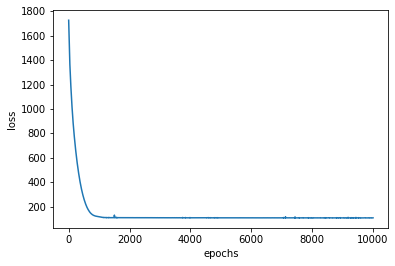

In [15]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("epochs")
plt.ylabel("loss")
_ = plt.show()

### Label vs Predictions Scatterplot

In [16]:
labels, predictions = [], []
hidden = None
with torch.no_grad():
  for inputs, targets in loader:
    inputs, targets = inputs.to(dev), targets.to(dev)
    
    preds, _ = net(inputs, hidden)
    for i in range(preds.shape[0]):
      predictions.append(preds[i][-1][0].detach().cpu().numpy())
      labels.append(targets[i][-1][0].detach().cpu().numpy())

len(labels), len(predictions)

(811, 811)

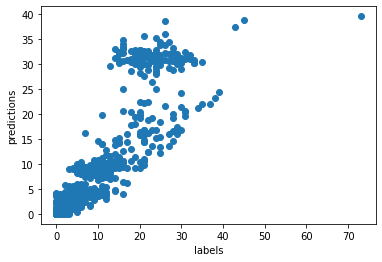

In [17]:
plt.scatter(labels, predictions)
plt.xlabel("labels")
plt.ylabel("predictions")
_ = plt.show()

In [18]:
!rm Sales_Transactions_Dataset_Weekly.csv*

## A.6.03 Sentiment Analysis

### Download data

In [19]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip
!unzip -a "sentiment labelled sentences.zip"
!ls "sentiment labelled sentences/"

--2020-08-15 22:58:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84188 (82K) [application/x-httpd-php]
Saving to: ‘sentiment labelled sentences.zip.1’

sentiment labelled  100%[===================>]  82.21K   297KB/s    in 0.3s    

2020-08-15 22:58:32 (297 KB/s) - ‘sentiment labelled sentences.zip.1’ saved [84188/84188]

Archive:  sentiment labelled sentences.zip
replace sentiment labelled sentences/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sentiment labelled sentences/.DS_Store  [binary]
  inflating: __MACOSX/sentiment labelled sentences/._.DS_Store  [binary]
  inflating: sentiment labelled sentences/amazon_cells_labelled.txt  [binary]
  inflating: sentiment labelled sentences/imdb_labelled.

In [20]:
!ls

 __MACOSX			'sentiment labelled sentences.zip'
 sample_data			'sentiment labelled sentences.zip.1'
'sentiment labelled sentences'


In [21]:
amazon_df = pd.read_csv("sentiment labelled sentences/amazon_cells_labelled.txt", sep="\t", 
                        names=["text", "label"])
amazon_df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [22]:
len(amazon_df)

1000

### Preprocess (Vectorize) Data

In [23]:
def remove_punctuation(text):
  text = text.lower()
  return text.translate(str.maketrans('', '', string.punctuation))

amazon_df["text_clean"] = amazon_df.apply(lambda row: remove_punctuation(row.text), axis=1)
amazon_df.head()

,text,label,text_clean
0,So there is no way for me to plug it in here i...,0,so there is no way for me to plug it in here i...
1,"Good case, Excellent value.",1,good case excellent value
2,Great for the jawbone.,1,great for the jawbone
3,Tied to charger for conversations lasting more...,0,tied to charger for conversations lasting more...
4,The mic is great.,1,the mic is great


In [24]:
texts = amazon_df["text_clean"].values
labels = amazon_df["label"].values

vec = CountVectorizer()
X = vec.fit_transform(texts).todense()

y = np.array(labels, dtype=np.int64).reshape(-1, 1)

X.shape, y.shape

((1000, 1892), (1000, 1))

In [25]:
word2idx = vec.vocabulary_
idx2word = {v:k for k, v in word2idx.items()}

### Dataset

In [26]:
Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.1, random_state=0)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, random_state=0)

Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((720, 1892), (720, 1), (180, 1892), (180, 1), (100, 1892), (100, 1))

In [27]:
train_ds = TensorDataset(torch.tensor(Xtrain, dtype=torch.int64),
                         torch.tensor(ytrain, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(Xval, dtype=torch.int64),
                       torch.tensor(yval, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(Xtest, dtype=torch.int64), 
                        torch.tensor(ytest, dtype=torch.float32))

In [28]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

### Network

In [29]:
class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_size, num_layers):
    super(SentimentLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers)
    self.output = nn.Linear(hidden_size, 1)

  def forward(self, x, states):
    out = self.embedding(x)
    out, states = self.lstm(out, states)
    out = torch.mean(out, axis=1)
    out = torch.sigmoid(self.output(out))
    return out, states

  def init_states(self):
    self.hidden.detach_()

net2 = SentimentLSTM(len(word2idx), 64, 128, 3)
print(net2)

SentimentLSTM(
  (embedding): Embedding(1892, 64)
  (lstm): LSTM(64, 128, num_layers=3)
  (output): Linear(in_features=128, out_features=1, bias=True)
)


In [30]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net2 = net2.to(dev)

### Training Loop

In [31]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=0.1)
num_epochs = 10

In [32]:
def evaluate(model, dev, loader):
  hidden = None
  y_true, y_pred = [], []
  with torch.no_grad():
    for inputs, targets in loader:
      inputs, targets = inputs.to(dev), targets.to(dev)
      pred, hidden = model(inputs, hidden)
      y_pred.extend(np.round(pred.detach().cpu()).tolist())
      y_true.extend(np.round(targets.detach().cpu()).tolist())
  return accuracy_score(y_pred, y_true)


In [33]:
num_epochs = 10

losses, accuracies, val_accuracies = [], [], []
for i in range(1, num_epochs + 1):

  hidden = None

  epoch_loss = 0
  y_true, y_pred = [], []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(dev), targets.to(dev)

    pred, hidden = net2(inputs, hidden)
    loss = loss_fn(pred, targets)

    epoch_loss += loss.detach().cpu().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hidden = repackage_hidden(hidden)

    y_pred.extend(np.round(pred.detach().cpu()).tolist())
    y_true.extend(np.round(targets.detach().cpu()).tolist())

  # validation accuracy
  val_acc = evaluate(net2, dev, val_loader)
  val_accuracies.append(val_acc)
  # calculate train loss and accuracy per epoch
  losses.append(epoch_loss)
  epoch_accuracy = accuracy_score(y_true, y_pred)
  accuracies.append(epoch_accuracy)

  print("Epoch {:d}, train loss: {:.3f}, accuracy: {:.3f}, val acc: {:.3f}".format(
      i, epoch_loss, epoch_accuracy, val_acc))


Epoch 1, train loss: 21.892, accuracy: 0.463, val acc: 0.478
Epoch 2, train loss: 16.581, accuracy: 0.521, val acc: 0.478
Epoch 3, train loss: 16.811, accuracy: 0.521, val acc: 0.478
Epoch 4, train loss: 16.946, accuracy: 0.521, val acc: 0.478
Epoch 5, train loss: 17.149, accuracy: 0.499, val acc: 0.478
Epoch 6, train loss: 17.293, accuracy: 0.493, val acc: 0.478
Epoch 7, train loss: 17.290, accuracy: 0.493, val acc: 0.478
Epoch 8, train loss: 17.257, accuracy: 0.493, val acc: 0.478
Epoch 9, train loss: 17.230, accuracy: 0.493, val acc: 0.478
Epoch 10, train loss: 17.212, accuracy: 0.493, val acc: 0.478


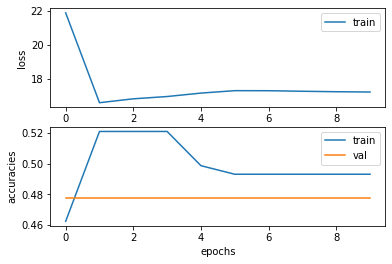

In [34]:
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(losses)), losses, label="train")
plt.legend(loc="best")
plt.ylabel("loss")

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(accuracies)), accuracies, label="train")
plt.plot(np.arange(len(accuracies)), val_accuracies, label="val")
plt.ylabel("accuracies")
plt.xlabel("epochs")
plt.legend(loc="best")

_ = plt.show()

In [35]:
test_acc = evaluate(net2, dev, test_loader)
print("Test accuracy: {:.3f}".format(test_acc))

Test accuracy: 0.530


In [36]:
!rm -f "sentiment labelled sentences.zip"
!rm -rf "sentiment labelled sentences"